# Autoregressive flow example
Given a dataset, we'd like to sample more data from (approximately) the same distribution. 

Strategy is to use an NF trained with Foward KL (MLE).

This requires invertibility of the NF to sample (one direction) and compute the loss (inverse direction). 

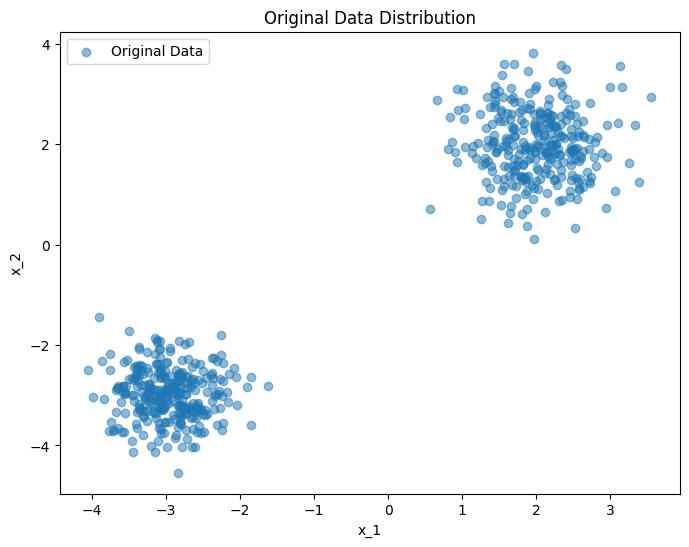

In [43]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

# Create a simple 2D dataset (e.g., a mixture of Gaussians)
def create_2d_data(n_samples, means, stds):
    data = []
    for i in range(len(means)):
        x = np.random.normal(loc=means[i][0], scale=stds[i][0], size=n_samples)
        y = np.random.normal(loc=means[i][1], scale=stds[i][1], size=n_samples)
        data.append(np.stack([x,y], axis = -1))

    data = np.concatenate(data, axis=0)

    return torch.tensor(data, dtype=torch.float32)

n_samples = 300
means = [[2, 2], [-3, -3]]
stds = [[.5,.7], [.4, .5]]

data = create_2d_data(n_samples, means, stds)

# 1. Plot Original Data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], label="Original Data", alpha=0.5)
plt.title("Original Data Distribution")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
plt.show()

## Forward Transformation per Layer

We have a 2D input vector $x = [x_1, x_2]^t$.


For first output $z_1$: $z_1 = x_1 \sigma_1 + \mu_1$, where the constants are just parameters of the NN. (linear function)

For second output $z_2$: apply a linear  layer (matrix multiply + bias), then relu, then another linear layer (matrix multiply + bias) to $[z_1, x_2]^T$. 

\begin{align}
[z_1, x_2]^T \mapsto C_{2,m}\text{ReLu}(A_{m,2} [z_1, x_2]^T + [b_1,...,b_m]^T) + [d_1, d_2]^T = [\mu_2, \log \sigma_2]^T
\end{align}

We have $\mu_2(x_1)$ and $\log \sigma_2(x_1)$, functions of $x_1$ (represented as outputs of a neural network that takes $x_1$ as input). Then 

$z_2 = x_2 * \sigma_2(x_1) + \mu_2(x_1)$

Output: The output of the MADE layer is $z = [z1, z2]^T$.



## Jacobian Calculation
The Jacobian matrix J is a 2x_2 matrix of partial derivatives:
\begin{align}
\frac{\partial z_1}{\partial x_1} &=  \sigma_1 \\
\frac{\partial z_1}{\partial x_2} &= 0 \quad \text{(because } z_1 \text{ doesn't depend on } x_2) \\
\frac{\partial z_2}{\partial x_1} &= x_2 \cdot  \sigma_2(x_1) \cdot \frac{\partial (\log \sigma_2(x_1))}{\partial x_1} + \frac{\partial (\mu_2(x_1))}{\partial x_1} \quad \text{(chain rule)} \\
\frac{\partial z_2}{\partial x_2} &=  \sigma_2(x_1)
\end{align}

So 
$$ \det(J) = \sigma_σ * \sigma_2(x_1) $$ 



## Inverse Transformation

The inverse transformation involves reversing the steps of the forward transformation:

Input: $z = [z1, z2]^T$

Inverse MADE:
$\mu_1$ and $\sigma_1$ are in our NN, so we can just use them to reconstruct $x_1$:

$x_1 = (z1 - \mu_1) / \sigma_1$

$x_2 = (z2 - \mu_2(x_1)) / \sigma_2(x_1) $

Output: $x = [x_1, x_2]^T$

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MAF2D(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # For the first dimension, we use constants for mu1 and log_sigma1
        self.mu1 = nn.Parameter(torch.zeros(1))
        self.log_sigma1 = nn.Parameter(torch.zeros(1))
        
        # For x2, we condition on x1
        self.net2 = nn.Sequential(  
            nn.Linear(1, hidden_dim),  # input is x1
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)   # Outputs μ2 and log σ2
        )
        
    def forward(self, x):
        # x1 transformation
        x1 = x[:, 0:1]
        mu1 = self.mu1.expand_as(x1)          # mu1 is constant
        log_sigma1 = self.log_sigma1.expand_as(x1)  # log_sigma1 is constant
        z1 = x1 * torch.exp(log_sigma1) + mu1  # Since mu1 and log_sigma1 are zeros initially, z1 = x1

        # x2 transformation conditioned on x1
        x2 = x[:, 1:2]
        out2 = self.net2(x1)  # net2 takes x1 as input
        mu2, log_sigma2 = torch.chunk(out2, 2, dim=-1)
        z2 = x2 * torch.exp(log_sigma2) + mu2

        z = torch.cat([z1, z2], dim=1)
        log_det = log_sigma1 + log_sigma2  # Sum of log-determinants
        return z, log_det.squeeze()
    
    def inverse(self, z):
        # x1 inversion
        z1 = z[:, 0:1]
        mu1 = self.mu1.expand_as(z1)
        log_sigma1 = self.log_sigma1.expand_as(z1)
        x1 = (z1 - mu1) / torch.exp(log_sigma1)  # Since mu1 and log_sigma1 are zeros, x1 = z1

        # x2 inversion conditioned on x1
        z2 = z[:, 1:2]
        out2 = self.net2(x1)  # Use x1 to compute mu2 and log_sigma2
        mu2, log_sigma2 = torch.chunk(out2, 2, dim=-1)
        x2 = (z2 - mu2) / torch.exp(log_sigma2)

        x = torch.cat([x1, x2], dim=1)
        return x

In [45]:
## unit test to see inverse works
hidden_dim = 10  # Example hidden dimension
maf = MAF2D(hidden_dim)

x = torch.randn(1, 2)  # Batch size of 1, 2D input
x.requires_grad_(False) # allows gradient computation for jacobian of arbitrary tensor x.
# Forward pass
z, log_det = maf(x)

print("Original x:", x)
print("Transformed z:", z)
print("Log Determinant:", log_det)
print(f"Inverting output gives: {maf.inverse(z)}")

Original x: tensor([[-0.3392, -0.7267]])
Transformed z: tensor([[-0.3392, -0.3644]], grad_fn=<CatBackward0>)
Log Determinant: tensor(-0.1829, grad_fn=<SqueezeBackward0>)
Inverting output gives: tensor([[-0.3392, -0.7267]], grad_fn=<CatBackward0>)


## Does this NF work? 

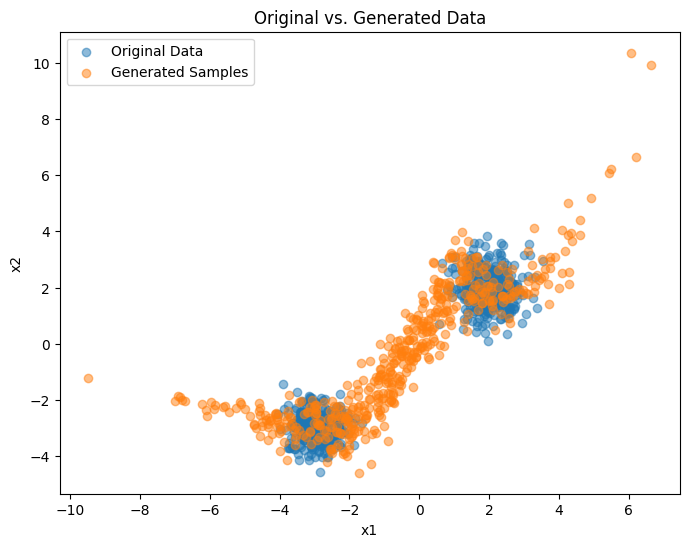

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.distributions as D

# optimizer = torch.optim.Adam(maf.parameters(), lr=1e-2)
optimizer = torch.optim.RMSprop(
    params = maf.parameters(),
    lr = 1e-3,
    momentum = .9
)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1000)

epochs = 2000
input_dim = 2

data_loader = torch.utils.data.DataLoader(data, batch_size=500, shuffle=True)

for epoch in range(epochs):
    for batch_idx, data_batch in enumerate(data_loader):
        optimizer.zero_grad()
        z, log_det = maf(data_batch) ## push given data thru NF, and compute log_det_jacobian values
        base_dist = D.Normal(torch.zeros(input_dim), torch.ones(input_dim)) # compute log prob of push_thru data with base distribution
        log_prob = base_dist.log_prob(z).sum(-1)
        loss = -(log_prob + log_det).mean()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

# Plotting samples after training
num_samples = 500  # Number of samples to generate
base_dist = D.Normal(torch.zeros(input_dim), torch.ones(input_dim))
z = base_dist.sample((num_samples,))
samples = maf.inverse(z).detach().numpy()


# plt.figure(figsize=(8, 6))
# plt.scatter(samples[:, 0], samples[:, 1], label="Generated Samples", alpha=0.5)
# plt.title("Generated Samples (After Training)")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend()

# plt.show()

# Plot both together for comparison:
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], label="Original Data", alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], label="Generated Samples", alpha=0.5)
plt.title("Original vs. Generated Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## Need more expressability! ---> Masking
- Note that in this NF the first input $x_1\mapsto x_1 *\sigma_1 + \mu_1$, so no way to move a bimodal density to a unimodal! 
- solution: 
    - add more layers
    - alternate $x_1, x_2$ in every other layer, so $z_1$ can depend on both $x_1, x_2$. 


In [49]:
import torch
import torch.nn as nn

class MAFLayer2D(nn.Module):
    def __init__(self, hidden_dim, mask_type):
        super().__init__()
        # mask_type can be 'one' or 'two' to denote the ordering
        self.mask_type = mask_type
        if mask_type == 'one':
            # x1 is transformed independently (uses learned parameters)
            self.mu1 = nn.Parameter(torch.zeros(1))
            self.log_sigma1 = nn.Parameter(torch.zeros(1))
            # x2 is transformed conditioned on x1
            self.net2 = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 2)  # Outputs μ2 and log σ2
            )
        elif mask_type == 'two':
            # x2 is transformed independently
            self.mu2 = nn.Parameter(torch.zeros(1))
            self.log_sigma2 = nn.Parameter(torch.zeros(1))
            # x1 is transformed conditioned on x2
            self.net1 = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 2)  # Outputs μ1 and log σ1
            )
        else:
            raise ValueError("Invalid mask_type specified. Use 'one' or 'two'.")
    
    def forward(self, x):
        x1 = x[:, 0:1]
        x2 = x[:, 1:2]
        if self.mask_type == 'one':
            # Transform x1 independently
            mu1 = self.mu1.expand_as(x1)
            log_sigma1 = self.log_sigma1.expand_as(x1)
            z1 = x1 * torch.exp(log_sigma1) + mu1
            # Transform x2 conditioned on x1
            out2 = self.net2(x1)
            mu2, log_sigma2 = torch.chunk(out2, 2, dim=-1)
            z2 = x2 * torch.exp(log_sigma2) + mu2
            log_det = log_sigma1 + log_sigma2
        else:
            # Transform x2 independently
            mu2 = self.mu2.expand_as(x2)
            log_sigma2 = self.log_sigma2.expand_as(x2)
            z2 = x2 * torch.exp(log_sigma2) + mu2
            # Transform x1 conditioned on x2
            out1 = self.net1(x2)
            mu1, log_sigma1 = torch.chunk(out1, 2, dim=-1)
            z1 = x1 * torch.exp(log_sigma1) + mu1
            log_det = log_sigma2 + log_sigma1
        z = torch.cat([z1, z2], dim=1)
        return z, log_det.squeeze()
    
    def inverse(self, z):
        z1 = z[:, 0:1]
        z2 = z[:, 1:2]
        if self.mask_type == 'one':
            # Inverse transform x1 independently
            mu1 = self.mu1.expand_as(z1)
            log_sigma1 = self.log_sigma1.expand_as(z1)
            x1 = (z1 - mu1) / torch.exp(log_sigma1)
            # Inverse transform x2 conditioned on x1
            out2 = self.net2(x1)
            mu2, log_sigma2 = torch.chunk(out2, 2, dim=-1)
            x2 = (z2 - mu2) / torch.exp(log_sigma2)
        else:
            # Inverse transform x2 independently
            mu2 = self.mu2.expand_as(z2)
            log_sigma2 = self.log_sigma2.expand_as(z2)
            x2 = (z2 - mu2) / torch.exp(log_sigma2)
            # Inverse transform x1 conditioned on x2
            out1 = self.net1(x2)
            mu1, log_sigma1 = torch.chunk(out1, 2, dim=-1)
            x1 = (z1 - mu1) / torch.exp(log_sigma1)
        x = torch.cat([x1, x2], dim=1)
        return x

class MAF2D(nn.Module):
    def __init__(self, hidden_dim, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        # Alternate mask types to ensure all dimensions are transformed
        mask_types = ['one', 'two'] * (n_layers // 2)
        if n_layers % 2 != 0:
            mask_types.append('one')
        for mask_type in mask_types:
            self.layers.append(MAFLayer2D(hidden_dim, mask_type))
    
    def forward(self, x):
        log_det = 0
        for layer in self.layers:
            x, ld = layer(x)
            log_det += ld
        return x, log_det
    
    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

In [53]:
# unit test for invertibility 
hidden_dim = 16
n_layers = 4  # Number of MAF layers
model = MAF2D(hidden_dim=hidden_dim, n_layers=n_layers)

# Generate random input data x
x = torch.randn(5, 2)  # Batch size of 5

# Forward pass
z, log_det = model(x)

# Inverse pass
x_reconstructed = model.inverse(z)

# Check the difference
print('Original x:\n', x)
print('Reconstructed x:\n', x_reconstructed)
# print('Difference:\n', x - x_reconstructed)
print('Max difference:', (x - x_reconstructed).abs().max())

Original x:
 tensor([[ 0.6233,  1.4262],
        [-1.0765, -0.9834],
        [ 2.2577,  0.4713],
        [ 1.1638,  0.7369],
        [-1.2388,  0.1027]])
Reconstructed x:
 tensor([[ 0.6233,  1.4262],
        [-1.0765, -0.9834],
        [ 2.2577,  0.4713],
        [ 1.1638,  0.7369],
        [-1.2388,  0.1027]], grad_fn=<CatBackward0>)
Max difference: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


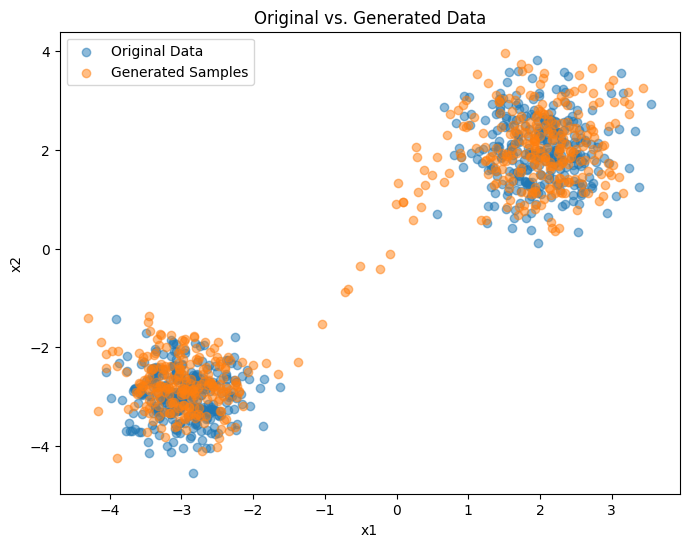

In [54]:
# optimizer = torch.optim.Adam(maf.parameters(), lr=1e-2)
optimizer = torch.optim.RMSprop(
    params = model.parameters(),
    lr = 1e-3,
    momentum = .9
)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1000)

epochs = 2000
input_dim = 2

data_loader = torch.utils.data.DataLoader(data, batch_size=500, shuffle=True)

for epoch in range(epochs):
    for batch_idx, data_batch in enumerate(data_loader):
        optimizer.zero_grad()
        z, log_det = model(data_batch) ## push given data thru NF, and compute log_det_jacobian values
        base_dist = D.Normal(torch.zeros(input_dim), torch.ones(input_dim)) # compute log prob of push_thru data with base distribution
        log_prob = base_dist.log_prob(z).sum(-1)
        loss = -(log_prob + log_det).mean()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

# Plotting samples after training
num_samples = 500  # Number of samples to generate
base_dist = D.Normal(torch.zeros(input_dim), torch.ones(input_dim))
z = base_dist.sample((num_samples,))
samples = model.inverse(z).detach().numpy()


# plt.figure(figsize=(8, 6))
# plt.scatter(samples[:, 0], samples[:, 1], label="Generated Samples", alpha=0.5)
# plt.title("Generated Samples (After Training)")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend()

# plt.show()

# Plot both together for comparison:
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], label="Original Data", alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], label="Generated Samples", alpha=0.5)
plt.title("Original vs. Generated Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()